## 6.2 Pytorch Nn Module
Pytorch has a whole submodule dedicated to neural networks, called $torch.nn$. A module can have one or more $Parameter$ instances as attributes, which are tensors whose values are optimized during the training process. We'll now start precisely where we left off and convert our previous code to a form that uses $nn$.

All pytorch-provided subclass of nn.Module have their __call__ method defined.

In [14]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [2]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8,  4,  7,  5,  3,  2,  6, 10,  9]), tensor([0, 1]))

In [8]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

The constructor to nn.Linear accepts three arguments: the number of input features, the number of output features, and whether the linear model includes a bias or not.

In [6]:
import torch.nn as nn

# the arguments are input size, output size, and bias defaulting to True
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[4.1989],
        [6.0960]], grad_fn=<AddmmBackward>)

We have an instance of nn.Linear with one input and one output feature. That only requires one weight and one bias:

In [10]:
linear_model.weight

Parameter containing:
tensor([[0.9392]], requires_grad=True)

In [11]:
linear_model.bias

Parameter containing:
tensor([0.8460], requires_grad=True)

We can call the module with some input:

In [12]:
x = torch.ones(1)
linear_model(x)

tensor([1.7852], grad_fn=<AddBackward0>)

To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the *batch*.

Assuming we need to run nn.Linear on 10 samples, we can create an input tensor of size B\*Nin, where B is the size of the batch and Nin is the number of input features, and run it once through the model.

In [13]:
x = torch.ones(10,1)
linear_model(x)

tensor([[1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852],
        [1.7852]], grad_fn=<AddmmBackward>)

In [16]:
import torch.optim as optim
import numpy as np

linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(),
                      lr=1e-2)

We can use the $parameters$ method to ask nn.Module for a list of parameters owned by it or any of its submodules

In [17]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7059]], requires_grad=True),
 Parameter containing:
 tensor([0.3269], requires_grad=True)]

Let's take a look at the training loop:

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

nn comes with several common loss functions, among them nn.MSELoss, which is exactly what we defined earlier as our loss\_fn. In our case, we get rid of the handwritten loss\_fn and replace it:

In [20]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs = 3000,
              optimizer = optimizer,
              model = linear_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

Epoch 1, Training loss 148.1235, Validation loss 68.4649
Epoch 1000, Training loss 3.8682, Validation loss 4.2091
Epoch 2000, Training loss 3.1740, Validation loss 2.3573
Epoch 3000, Training loss 3.1538, Validation loss 2.1233


In [21]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[5.2464]], requires_grad=True),
 Parameter containing:
 tensor([-16.6466], requires_grad=True)]

Everything else input into our training loop stays the same.

## 6.3 Finally a neural network
6.3.1 Replacing the linear model

nn provides a simple way to concatenate modules through the nn.Sequential container:

In [23]:
seq_model = nn.Sequential(nn.Linear(1,13),
                          nn.Tanh(),
                          nn.Linear(13,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified as an argument of nn.Sequential. The model fans out from 1 input feature to 13 hidden features, passes them through a $tanh$ activation, and linearly combines the resulting 13 numbers into 1 output feature.

6.3.2 Inspecting the parameters

When inspecting parameters of a model made up of several submodules, it's handy to be able to identify parameters by name.

In [24]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Some useless named layer code.

In [25]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 8)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(8, 1))]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [26]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


We can run the training loop for the new neural network model and then look at the resulting gradients after the last epoch:

In [27]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 220.6038, Validation loss 106.4698
Epoch 1000, Training loss 4.8055, Validation loss 1.6711
Epoch 2000, Training loss 3.3088, Validation loss 1.8405
Epoch 3000, Training loss 1.7310, Validation loss 3.4301
Epoch 4000, Training loss 1.3478, Validation loss 4.5850
Epoch 5000, Training loss 1.2481, Validation loss 5.2160
output tensor([[ 2.6640],
        [10.9336]], grad_fn=<AddmmBackward>)
answer tensor([[ 0.5000],
        [14.0000]])
hidden tensor([[ -0.2901],
        [-11.9619],
        [ -0.9858],
        [ 12.8981],
        [-12.7594],
        [ -0.9862],
        [ -0.9548],
        [ -0.0131]])


6.3.3 Comparing to the linear model

We can also evaluate the model on all of the data and see how it differs from a line:

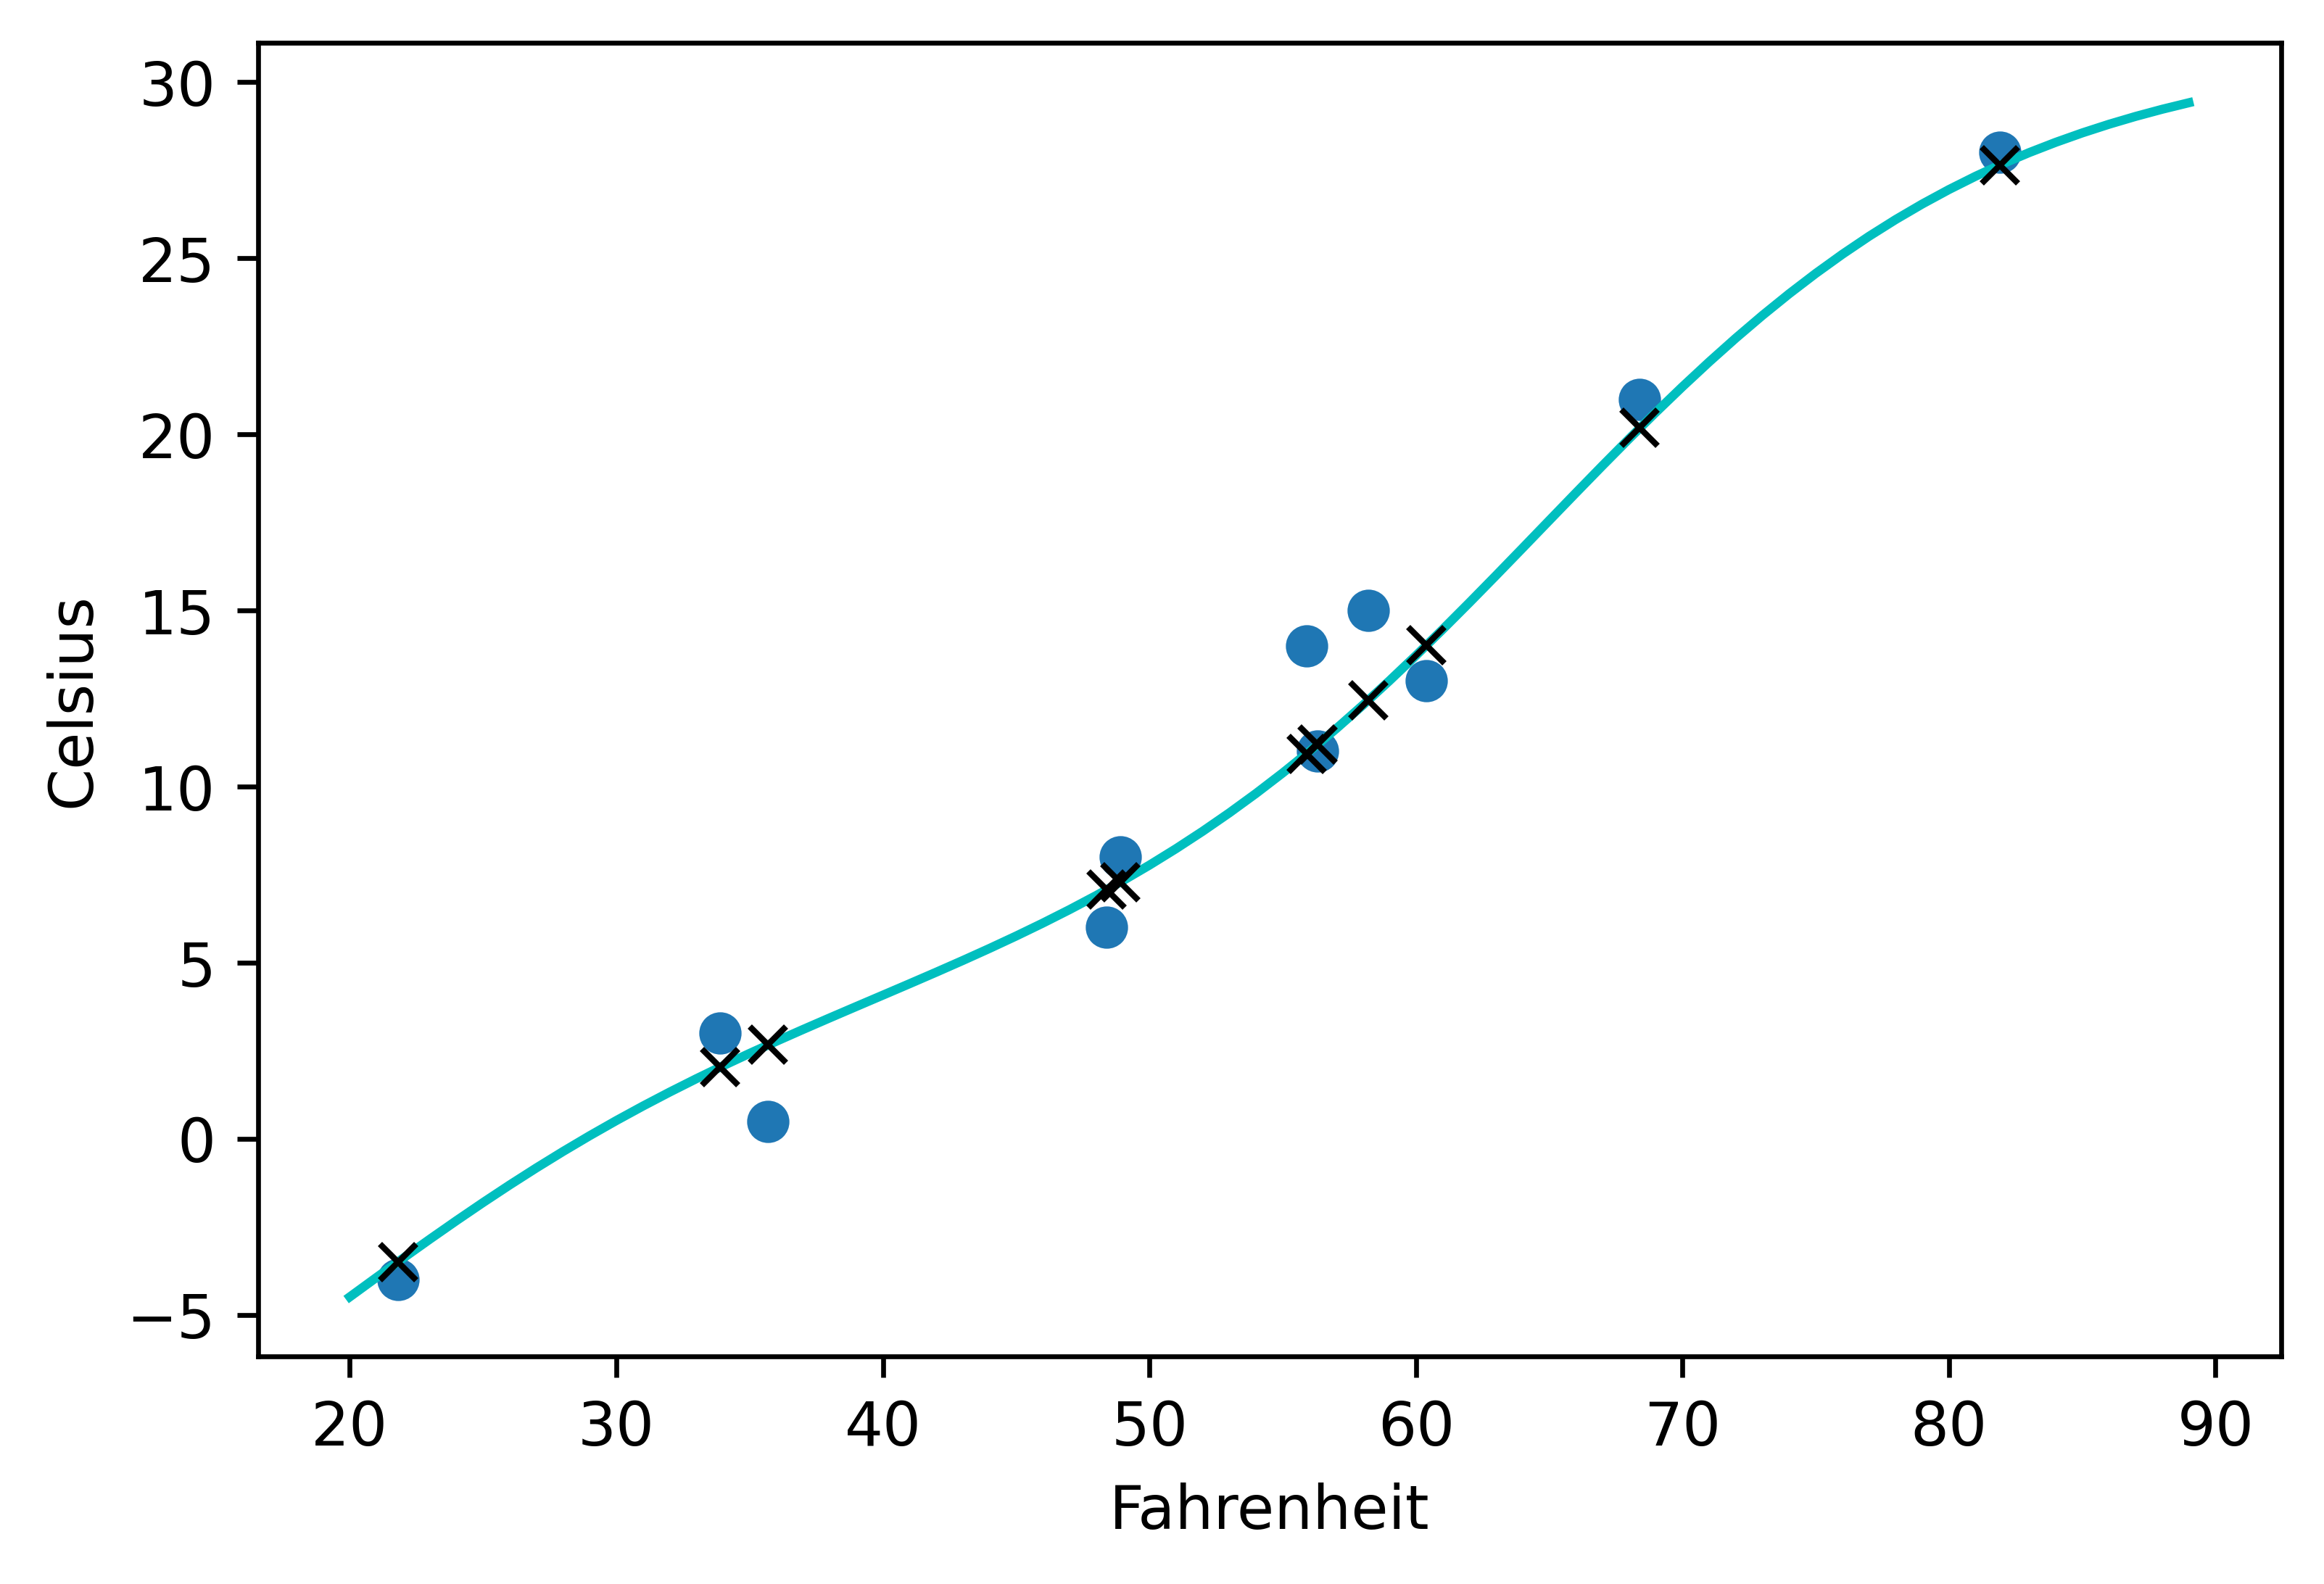

In [28]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')